# Import Dependencies

In [54]:
!pip install fasttext


In [55]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [56]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Influencer Category Classification



1.   Read Data
2.   Preprocess Data
3.   Prepare Model
4.   Predict Test Data
4.   Save outputs



In [57]:
train_classification_df = pd.read_csv("/content/train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [58]:
# stats about the labels
train_classification_df.groupby("category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [59]:
username2_category["kod8net"]

'tech'

In [60]:
train_data_path = "/content/training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [61]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [62]:
test_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,None,1265,665,True,False,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,None,28025,4,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


#TF_IDF
words are not numbers, we should transform them to numerical values

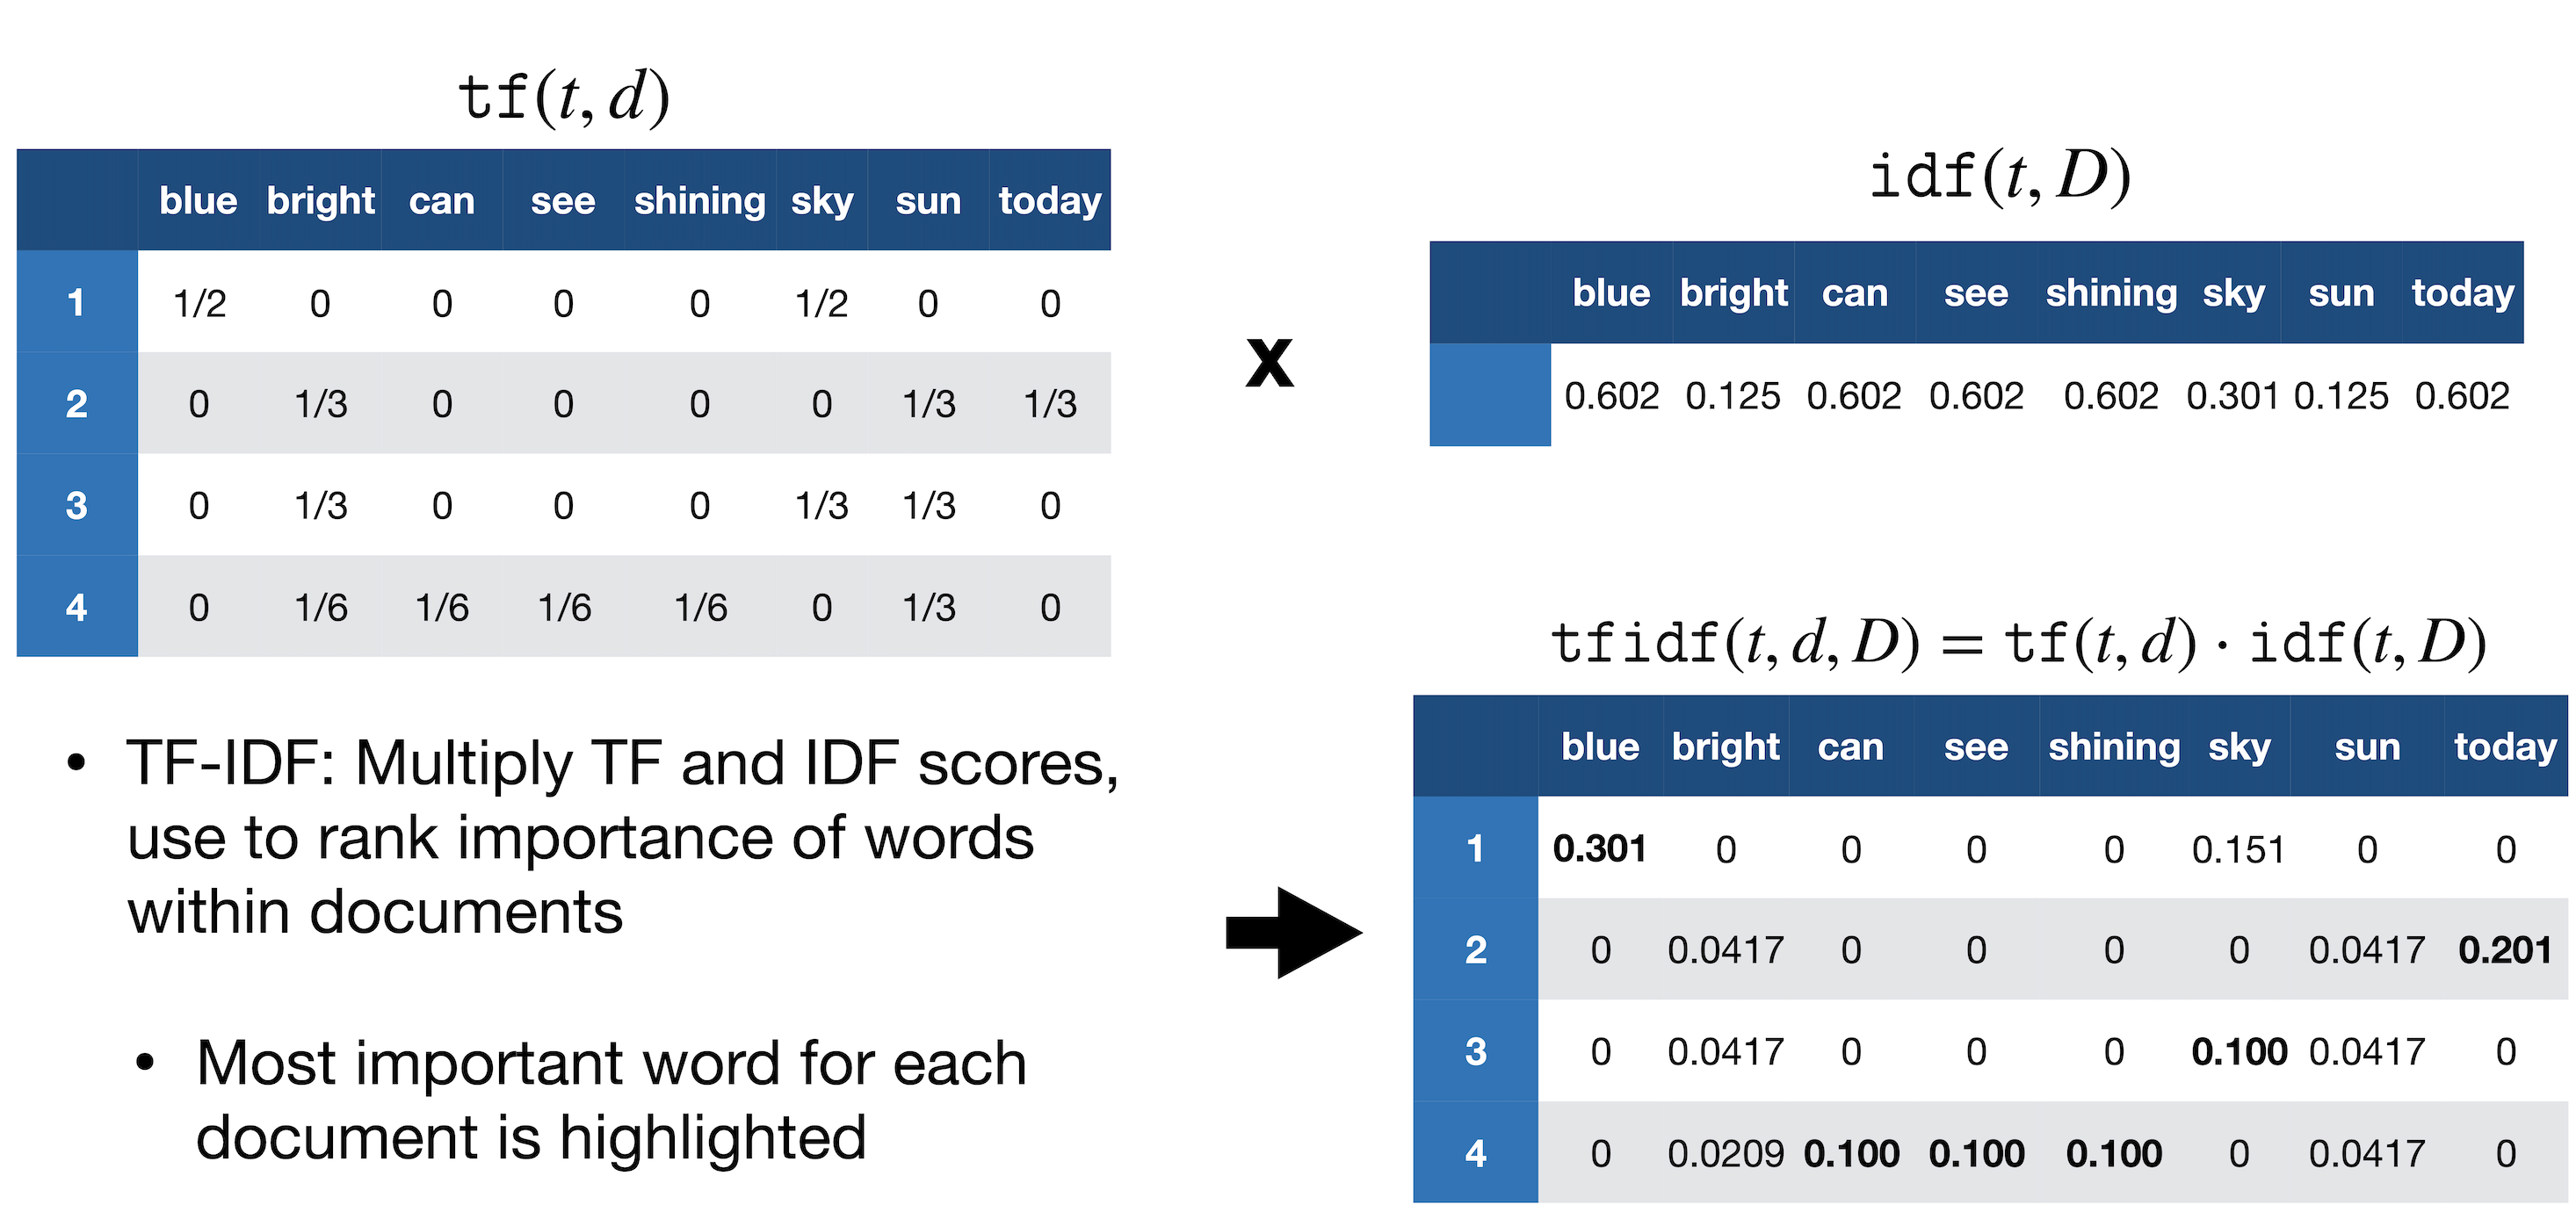

# Let's check the documentation of scikit-learn
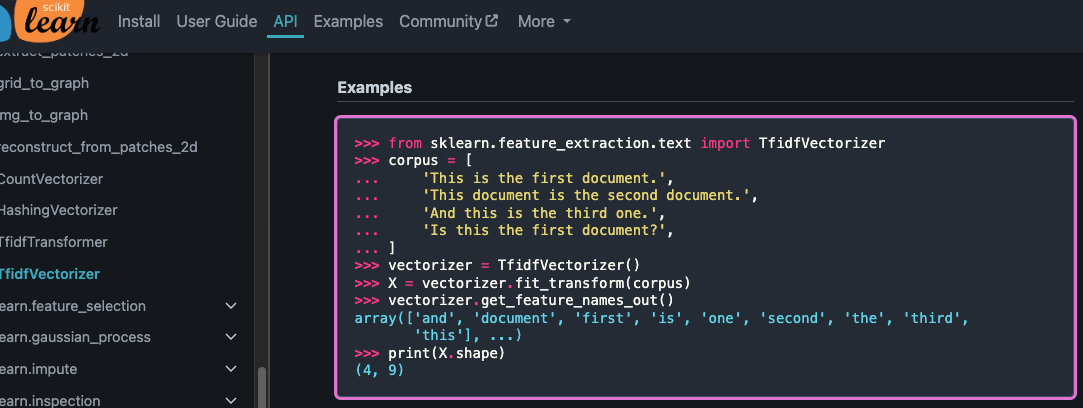

Here our corpus is all of our post data
so we should concat aggregate all of them and provide as a corpus to the Tf-IDF vectorizer of the scikit-learn.

In [63]:
import fasttext
import re
from collections import Counter

def preprocess_text(text: str):
    text = text.casefold()  # Lowercase for Turkish text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

# First, let's analyze the categories in both training and test sets
print("=== Category Distribution Analysis ===")
train_categories = Counter(username2_category.get(username, "NA") for username in username2posts_train.keys())
test_categories = Counter(username2_category.get(username, "NA") for username in username2posts_test.keys())

print("\nTraining categories distribution:")
print(train_categories)
print("\nTest categories distribution:")
print(test_categories)

# Create training data file for FastText
print("\n=== Creating Training Data ===")
train_count = 0
with open("fasttext_train.txt", "w", encoding="utf-8") as f:
    for username, posts in username2posts_train.items():
        category = username2_category.get(username, "NA")
        if category == "NA":  # Skip entries with no category
            continue

        cleaned_captions = [preprocess_text(post.get("caption", "")) for post in posts if post.get("caption", "")]
        if not cleaned_captions:  # Skip if no valid captions
            continue

        user_text = " ".join(cleaned_captions)
        if user_text.strip():  # Only write if there's actual text
            f.write(f"__label__{category} {user_text}\n")
            train_count += 1

print(f"Written {train_count} training examples")

# Create test data file for FastText
print("\n=== Creating Test Data ===")
test_count = 0
with open("fasttext_test.txt", "w", encoding="utf-8") as f:
    for username, posts in username2posts_test.items():
        category = username2_category.get(username)
        if category is None or category == "NA":
            continue

        cleaned_captions = [preprocess_text(post.get("caption", "")) for post in posts if post.get("caption", "")]
        if not cleaned_captions:
            continue

        user_text = " ".join(cleaned_captions)
        if user_text.strip():
            f.write(f"__label__{category} {user_text}\n")
            test_count += 1

print(f"Written {test_count} test examples")

# Only proceed with training if we have both training and test data
if train_count > 0 and test_count > 0:
    print("\n=== Training Model ===")
    # Train with more epochs and adjusted learning rate
    model = fasttext.train_supervised(
        input="fasttext_train.txt",
        epoch=25,  # Increased epochs
        lr=0.1,    # Lower learning rate for better stability
        wordNgrams=2,  # Add bigram features
        minCount=2  # Minimum occurrence of words
    )

    # Save the model
    model.save_model("fasttext_model.bin")

    # Evaluate on test data
    print("\n=== Evaluation Results ===")
    result = model.test("fasttext_test.txt")
    print(f"Samples: {result[0]}, Precision: {result[1]:.4f}, Recall: {result[2]:.4f}")
else:
    print("\nERROR: Insufficient data for training/testing. Please check your category mappings.")
    if train_count == 0:
        print("No valid training examples were generated.")
    if test_count == 0:
        print("No valid test examples were generated.")

=== Category Distribution Analysis ===

Training categories distribution:
Counter({'food': 511, 'health and lifestyle': 502, 'tech': 346, 'entertainment': 323, 'fashion': 299, 'travel': 294, 'art': 191, 'mom and children': 149, 'sports': 113, 'gaming': 13})

Test categories distribution:
Counter({'NA': 2674})

=== Creating Training Data ===
Written 2734 training examples

=== Creating Test Data ===
Written 0 test examples

ERROR: Insufficient data for training/testing. Please check your category mappings.
No valid test examples were generated.


In [64]:
# ✅ Train the FastText model
model = fasttext.train_supervised(input="fasttext_train.txt", epoch=10, lr=0.5)

# ✅ Save the model
model.save_model("fasttext_model.bin")


In [65]:
# ✅ Evaluate on test data
result = model.test("fasttext_test.txt")
print(f"Samples: {result[0]}, Precision: {result[1]:.4f}, Recall: {result[2]:.4f}")



Samples: 0, Precision: nan, Recall: nan


In [66]:
import fasttext
import re
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_text(text: str):
    text = text.casefold()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# First create the full training dataset
print("=== Preparing Training Data ===")
train_texts = []
train_labels = []
for username, posts in username2posts_train.items():
    cleaned_captions = [preprocess_text(post.get("caption", "")) for post in posts if post.get("caption", "")]
    if cleaned_captions:
        user_text = " ".join(cleaned_captions)
        category = username2_category.get(username, "NA")
        if category != "NA":
            train_texts.append(user_text)
            train_labels.append(category)

# Split into train and validation
print("\n=== Splitting Train/Validation Sets ===")
X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    train_texts, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

# Create training file
print("Creating training file...")
with open("fasttext_train.txt", "w", encoding="utf-8") as f:
    for text, label in zip(X_train_texts, y_train):
        f.write(f"__label__{label} {text}\n")

# Create validation file
print("Creating validation file...")
with open("fasttext_val.txt", "w", encoding="utf-8") as f:
    for text, label in zip(X_val_texts, y_val):
        f.write(f"__label__{label} {text}\n")

# Train the model
print("\n=== Training Model ===")
model = fasttext.train_supervised(
    input="fasttext_train.txt",
    epoch=25,
    lr=0.1,
    wordNgrams=2,
    minCount=2
)

# Evaluate on validation set
print("\n=== Validation Results ===")
val_result = model.test("fasttext_val.txt")
print(f"Validation - Samples: {val_result[0]}, Precision: {val_result[1]:.4f}, Recall: {val_result[2]:.4f}")

# Now predict categories for test data
print("\n=== Predicting Test Categories ===")
test_predictions = {}
for username, posts in username2posts_test.items():
    cleaned_captions = [preprocess_text(post.get("caption", "")) for post in posts if post.get("caption", "")]
    if cleaned_captions:
        user_text = " ".join(cleaned_captions)
        # Get prediction and probability
        prediction = model.predict(user_text)
        predicted_label = prediction[0][0].replace("__label__", "")
        prediction_prob = prediction[1][0]
        test_predictions[username] = (predicted_label, prediction_prob)

# Print sample predictions
print("\n=== Sample Test Predictions ===")
sample_size = min(5, len(test_predictions))
for username in list(test_predictions.keys())[:sample_size]:
    pred_label, prob = test_predictions[username]
    print(f"Username: {username}")
    print(f"Predicted Category: {pred_label}")
    print(f"Confidence: {prob:.4f}\n")

# Save predictions if needed
print("\n=== Prediction Statistics ===")
pred_categories = [pred[0] for pred in test_predictions.values()]
from collections import Counter
print("Predicted category distribution:")
print(Counter(pred_categories))

=== Preparing Training Data ===

=== Splitting Train/Validation Sets ===
Creating training file...
Creating validation file...

=== Training Model ===

=== Validation Results ===
Validation - Samples: 548, Precision: 0.1825, Recall: 0.1825

=== Predicting Test Categories ===

=== Sample Test Predictions ===
Username: beyazyakaliyiz
Predicted Category: health
Confidence: 0.1604

Username: totalenergies_istasyonlari
Predicted Category: health
Confidence: 0.2111

Username: konforyatak
Predicted Category: health
Confidence: 0.2484

Username: ht_kulup
Predicted Category: health
Confidence: 0.1350

Username: ajansspor
Predicted Category: health
Confidence: 0.1649


=== Prediction Statistics ===
Predicted category distribution:
Counter({'health': 2669})


In [67]:
import fasttext
import re
from sklearn.model_selection import train_test_split
from collections import Counter

def preprocess_text(text: str):
    if text is None:
        return ""

    # More careful preprocessing
    text = text.casefold()

    # Keep hashtags but remove #
    text = re.sub(r'#(\w+)', r'\1', text)

    # Keep mentions but remove @
    text = re.sub(r'@(\w+)', r'\1', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove emojis and special characters but keep Turkish characters
    text = re.sub(r'[^a-zçğıöşü0-9\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("=== Preparing Training Data ===")
# Prepare training data with minimum text length requirement
train_texts = []
train_labels = []
min_text_length = 20  # Minimum character length for training examples

for username, posts in username2posts_train.items():
    category = username2_category.get(username, "NA")
    if category == "NA":
        continue

    # Combine all posts for this user
    user_texts = []
    for post in posts:
        caption = post.get("caption", "")
        if caption:
            cleaned_text = preprocess_text(caption)
            if len(cleaned_text) > min_text_length:
                user_texts.append(cleaned_text)

    if user_texts:
        combined_text = " ".join(user_texts)
        train_texts.append(combined_text)
        train_labels.append(category)

print(f"Total training examples: {len(train_texts)}")
print("\nCategory distribution in training:")
print(Counter(train_labels))

# Split into train and validation
print("\n=== Splitting Train/Validation Sets ===")
X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    train_texts, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

# Create training file with augmented examples
print("Creating training file...")
with open("fasttext_train.txt", "w", encoding="utf-8") as f:
    for text, label in zip(X_train_texts, y_train):
        # Write original example
        f.write(f"__label__{label} {text}\n")

        # Write each sentence as a separate example (data augmentation)
        sentences = text.split('. ')
        if len(sentences) > 1:
            for sentence in sentences:
                if len(sentence) > min_text_length:
                    f.write(f"__label__{label} {sentence}\n")

# Create validation file
print("Creating validation file...")
with open("fasttext_val.txt", "w", encoding="utf-8") as f:
    for text, label in zip(X_val_texts, y_val):
        f.write(f"__label__{label} {text}\n")

# Train the model with improved parameters
print("\n=== Training Model ===")
model = fasttext.train_supervised(
    input="fasttext_train.txt",
    epoch=50,            # More epochs
    lr=0.05,            # Lower learning rate
    wordNgrams=3,       # Use trigrams
    minCount=2,         # Minimum word count
    loss='hs',          # Hierarchical softmax
    dim=300,            # Larger embedding dimension
    ws=7,              # Larger window size
    minn=3,            # Min length of char ngram
    maxn=6,            # Max length of char ngram
    neg=10             # Number of negative samples
)

# Evaluate on validation set
print("\n=== Validation Results ===")
val_result = model.test("fasttext_val.txt")
print(f"Validation - Samples: {val_result[0]}, Precision: {val_result[1]:.4f}, Recall: {val_result[2]:.4f}")

# Predict test categories with confidence threshold
print("\n=== Predicting Test Categories ===")
confidence_threshold = 0.3  # Minimum confidence threshold
test_predictions = {}

for username, posts in username2posts_test.items():
    user_texts = []
    for post in posts:
        caption = post.get("caption", "")
        if caption:
            cleaned_text = preprocess_text(caption)
            if len(cleaned_text) > min_text_length:
                user_texts.append(cleaned_text)

    if user_texts:
        combined_text = " ".join(user_texts)
        prediction = model.predict(combined_text)
        predicted_label = prediction[0][0].replace("__label__", "")
        prediction_prob = prediction[1][0]

        if prediction_prob >= confidence_threshold:
            test_predictions[username] = (predicted_label, prediction_prob)
        else:
            # For low confidence predictions, get top 3 predictions
            k = 3
            predictions = model.predict(combined_text, k=k)
            top_labels = [label.replace("__label__", "") for label in predictions[0]]
            top_probs = predictions[1]
            test_predictions[username] = (top_labels, top_probs)

# Print sample predictions
print("\n=== Sample Test Predictions ===")
sample_size = min(10, len(test_predictions))
for username in list(test_predictions.keys())[:sample_size]:
    pred = test_predictions[username]
    print(f"\nUsername: {username}")
    if isinstance(pred[0], str):
        print(f"Predicted Category: {pred[0]}")
        print(f"Confidence: {pred[1]:.4f}")
    else:
        print("Top 3 predictions:")
        for label, prob in zip(pred[0], pred[1]):
            print(f"{label}: {prob:.4f}")

# Print prediction statistics
print("\n=== Prediction Statistics ===")
# Count only high-confidence predictions
high_conf_preds = [pred[0] for pred in test_predictions.values() if isinstance(pred[0], str)]
print("\nHigh confidence prediction distribution:")
print(Counter(high_conf_preds))

# Save the model
model.save_model("fasttext_model.bin")

=== Preparing Training Data ===
Total training examples: 2729

Category distribution in training:
Counter({'food': 510, 'health and lifestyle': 500, 'tech': 344, 'entertainment': 321, 'fashion': 297, 'travel': 293, 'art': 189, 'mom and children': 149, 'sports': 113, 'gaming': 13})

=== Splitting Train/Validation Sets ===
Creating training file...
Creating validation file...

=== Training Model ===

=== Validation Results ===
Validation - Samples: 546, Precision: 0.1868, Recall: 0.1868

=== Predicting Test Categories ===

=== Sample Test Predictions ===

Username: beyazyakaliyiz
Top 3 predictions:
food: 0.2499
health: 0.1251
tech: 0.1250

Username: totalenergies_istasyonlari
Top 3 predictions:
food: 0.2498
health: 0.1251
tech: 0.1251

Username: konforyatak
Top 3 predictions:
food: 0.2499
health: 0.1251
tech: 0.1251

Username: ht_kulup
Top 3 predictions:
food: 0.2499
health: 0.1251
tech: 0.1250

Username: ajansspor
Top 3 predictions:
food: 0.2499
health: 0.1251
tech: 0.1250

Username: yu

In [ ]:
import fasttext
import re
from sklearn.model_selection import train_test_split
from collections import Counter

def preprocess_text(text: str):
    if text is None:
        return ""

    # More careful preprocessing
    text = text.casefold()

    # Keep hashtags but remove #
    text = re.sub(r'#(\w+)', r'\1', text)

    # Keep mentions but remove @
    text = re.sub(r'@(\w+)', r'\1', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove emojis and special characters but keep Turkish characters
    text = re.sub(r'[^a-zçğıöşü0-9\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("=== Preparing Training Data ===")
# Prepare training data with minimum text length requirement
train_texts = []
train_labels = []
min_text_length = 20  # Minimum character length for training examples

for username, posts in username2posts_train.items():
    category = username2_category.get(username, "NA")
    if category == "NA":
        continue

    # Combine all posts for this user
    user_texts = []
    for post in posts:
        caption = post.get("caption", "")
        if caption:
            cleaned_text = preprocess_text(caption)
            if len(cleaned_text) > min_text_length:
                user_texts.append(cleaned_text)

    if user_texts:
        combined_text = " ".join(user_texts)
        train_texts.append(combined_text)
        train_labels.append(category)

print(f"Total training examples: {len(train_texts)}")
print("\nCategory distribution in training:")
print(Counter(train_labels))

# Split into train and validation
print("\n=== Splitting Train/Validation Sets ===")
X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    train_texts, train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

# Create training file with augmented examples
print("Creating training file...")
with open("fasttext_train.txt", "w", encoding="utf-8") as f:
    for text, label in zip(X_train_texts, y_train):
        # Write original example
        f.write(f"__label__{label} {text}\n")

        # Write each sentence as a separate example (data augmentation)
        sentences = text.split('. ')
        if len(sentences) > 1:
            for sentence in sentences:
                if len(sentence) > min_text_length:
                    f.write(f"__label__{label} {sentence}\n")

# Create validation file
print("Creating validation file...")
with open("fasttext_val.txt", "w", encoding="utf-8") as f:
    for text, label in zip(X_val_texts, y_val):
        f.write(f"__label__{label} {text}\n")

# Train the model with improved parameters
print("\n=== Training Model ===")
model = fasttext.train_supervised(
    input="fasttext_train.txt",
    epoch=50,            # More epochs
    lr=0.05,            # Lower learning rate
    wordNgrams=3,       # Use trigrams
    minCount=2,         # Minimum word count
    loss='hs',          # Hierarchical softmax
    dim=300,            # Larger embedding dimension
    ws=7,              # Larger window size
    minn=3,            # Min length of char ngram
    maxn=6,            # Max length of char ngram
    neg=10             # Number of negative samples
)

# Evaluate on validation set
print("\n=== Validation Results ===")
val_result = model.test("fasttext_val.txt")
print(f"Validation - Samples: {val_result[0]}, Precision: {val_result[1]:.4f}, Recall: {val_result[2]:.4f}")

# Predict test categories with confidence threshold
print("\n=== Predicting Test Categories ===")
confidence_threshold = 0.3  # Minimum confidence threshold
test_predictions = {}

for username, posts in username2posts_test.items():
    user_texts = []
    for post in posts:
        caption = post.get("caption", "")
        if caption:
            cleaned_text = preprocess_text(caption)
            if len(cleaned_text) > min_text_length:
                user_texts.append(cleaned_text)

    if user_texts:
        combined_text = " ".join(user_texts)
        prediction = model.predict(combined_text)
        predicted_label = prediction[0][0].replace("__label__", "")
        prediction_prob = prediction[1][0]

        if prediction_prob >= confidence_threshold:
            test_predictions[username] = (predicted_label, prediction_prob)
        else:
            # For low confidence predictions, get top 3 predictions
            k = 3
            predictions = model.predict(combined_text, k=k)
            top_labels = [label.replace("__label__", "") for label in predictions[0]]
            top_probs = predictions[1]
            test_predictions[username] = (top_labels, top_probs)

# Print sample predictions
print("\n=== Sample Test Predictions ===")
sample_size = min(10, len(test_predictions))
for username in list(test_predictions.keys())[:sample_size]:
    pred = test_predictions[username]
    print(f"\nUsername: {username}")
    if isinstance(pred[0], str):
        print(f"Predicted Category: {pred[0]}")
        print(f"Confidence: {pred[1]:.4f}")
    else:
        print("Top 3 predictions:")
        for label, prob in zip(pred[0], pred[1]):
            print(f"{label}: {prob:.4f}")

# Print prediction statistics
print("\n=== Prediction Statistics ===")
# Count only high-confidence predictions
high_conf_preds = [pred[0] for pred in test_predictions.values() if isinstance(pred[0], str)]
print("\nHigh confidence prediction distribution:")
print(Counter(high_conf_preds))

# Save the model
model.save_model("fasttext_model.bin")

=== Preparing Training Data ===
Total training examples: 2729

Category distribution in training:
Counter({'food': 510, 'health and lifestyle': 500, 'tech': 344, 'entertainment': 321, 'fashion': 297, 'travel': 293, 'art': 189, 'mom and children': 149, 'sports': 113, 'gaming': 13})

=== Splitting Train/Validation Sets ===
Creating training file...
Creating validation file...

=== Training Model ===


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000)

# fit the vectorizer
vectorizer.fit(corpus)


# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [ ]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_names

In [ ]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

In [ ]:
df_tfidf.shape

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

In [ ]:
x_train.shape

In [ ]:
x_val.shape

# Naive Base Classifier

### Now we can pass the numerical values to a classifier, Let's try Naive Base!


In [ ]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


model = MultinomialNB()
model.fit(x_train, y_train)

In [ ]:
#@title Train Data
y_train_pred = model.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

In [ ]:
#@title Validation Data
y_val_pred = model.predict(x_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))

In [ ]:
#@title Test Data


# let's take a look at the first 5 lines of the file
test_data_path = "/content/test-classification-round1.dat"
!head -n 5 "$test_data_path"

print("*****")

test_unames = []
with open(test_data_path, "rt") as fh:
  for line in fh:
    test_unames.append(line.strip())

print(test_unames[:5])

In [ ]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)


test_unames.remove("screenname")

In [ ]:
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.head(2)

In [ ]:
test_pred = model.predict(df_test)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = test_pred[index]

In [ ]:
with open("output.json", "w") as of:
  json.dump(output, of, indent=4)

# Like Count Prediction


Here, we use the average like_count of the user's previous posts to predict each post's like_count

In [ ]:
def predict_like_count(username, current_post=None):
  def get_avg_like_count(posts:list):
    total = 0.
    for post in posts:
      if current_post is not None and post["id"] == current_post["id"]:
        continue

      like_count = post.get("like_count", 0)
      if like_count is None:
        like_count = 0
      total += like_count

    if len(posts) == 0:
      return 0.

    return total / len(posts)

  if username in username2posts_train:
    return get_avg_like_count(username2posts_train[username])
  elif username in username2posts_test:
    return get_avg_like_count(username2posts_test[username])
  else:
    print(f"No data available for {username}")
    return -1

In [ ]:
def log_mse_like_counts(y_true, y_pred):
  """
  Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).

  Parameters:
  - y_true: array-like, actual like counts
  - y_pred: array-like, predicted like counts

  Returns:
  - log_mse: float, Log Mean Squared Error
  """
  # Ensure inputs are numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Log transformation: log(like_count + 1)
  log_y_true = np.log1p(y_true)
  log_y_pred = np.log1p(y_pred)

  # Compute squared errors
  squared_errors = (log_y_true - log_y_pred) ** 2

  # Return the mean of squared errors
  return np.mean(squared_errors)

In [ ]:
#@title Train Dataset evaluation

y_like_count_train_true = []
y_like_count_train_pred = []
for uname, posts in username2posts_train.items():
  for post in posts:
    pred_val = predict_like_count(uname, post)
    true_val = post.get("like_count", 0)
    if true_val is None:
      true_val = 0

    y_like_count_train_true.append(true_val)
    y_like_count_train_pred.append(pred_val)

print(f"Log MSE Train= {log_mse_like_counts(y_like_count_train_true, y_like_count_train_pred)}")

In [ ]:
#@title Test Dataset

path = "/content/test-regression-round1.jsonl"
output_path = "/content/test-regression-round1.jsonl"

to_predict_like_counts_usernames = []
output_list = []
with open(path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    # let's predict
    pred_val = predict_like_count(sample["username"])
    sample["like_count"] = int(pred_val)
    output_list.append(sample)

with open(output_path, "wt") as of:
  json.dump(output_list, of)

In [ ]:
# output_list first 3 items
pprint(output_list[:3])